In [2]:
# 모듈로딩
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from itertools import groupby
from operator import itemgetter
from random import shuffle

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from tensorflow.keras.layers import Input,Dropout,LSTM,TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [3]:
def lstm_ae_model_tanh(x):
    model= tf.keras.Sequential([
        
        tf.keras.layers.Input(shape=(x.shape[1], x.shape[2])),
        tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.00)),
        tf.keras.layers.LSTM(8, activation='tanh', return_sequences=False),
        
        tf.keras.layers.RepeatVector(x.shape[1]),
        
        tf.keras.layers.LSTM(8, activation='tanh', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.00)),
        tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(x.shape[2]))
    ])

    return model

In [5]:
# load data
def data_load(data_dir):
    '''
    data_dir
    '''
    df = pd.read_csv(data_dir)

    df['dates'] = pd.to_datetime(df['dates'])

    df.sort_values('dates',inplace=True)
    df.reset_index(drop=True,inplace=True)

    return df

# data sclaer
def data_sclaer(data,column_list,sclaer):
    '''
    data,column_list, sclaer
    '''
    sclaer_data = sclaer.fit_transform(data[column_list])

    return sclaer_data

# 학습용 데이터 shape 맞추기
def data_shape(data,time_steps):
    '''
    data,time_steps
    
    return data(shape(row,time_steps,feature))
    '''
    data_list = []

    for i in range(len(data)-time_steps+1):
        data_list.append(data[i:(i+time_steps)])

    data_list = np.array(data_list)

    print(data_list.shape)

    return data_list

In [45]:
# threshold 설정
def thres(how,re_errors,k=1,percent=95):
    '''
    how : percentile, meank, iqr
    re_erros : reconstruction error
    k : default=1 
    percent : default = 95

    return threshold
    '''

    if how == 'precentile':

        threshold = np.percentile(re_errors,percent)

    elif how == 'meank':
        re_mean = np.mean(re_errors)
        re_std = np.std(re_errors)

        threshold = re_mean + k * re_std

    elif how == 'iqr':
        q1 = np.percentile(re_errors, 25)
        q3 = np.percentile(re_errors, 75)
        iqr = q3-q1

        threshold = q3 + 1.5 * iqr

    print(threshold)

    return threshold

In [7]:
# 모델 예측값 계산
def pred_val(time_step, pred_data):
    '''
    time_step
    pred_data : 모델 예측값 중 실체 측정 값
    
    return pred_results
    '''
    total_point = pred_data.shape[0] + time_step -1

    time_dict = defaultdict(list)

    for i in tqdm(range(pred_data.shape[0])):
        for j in range(time_step):
            start_time = i + j

        if start_time >= total_point:
            continue

        pred_val = pred_data[i,j,1]

        time_dict[start_time].append(pred_val)

    pred_results = []
    for t in sorted(time_dict.keys()):
        avg_pred = np.mean(time_dict[t])
        pred_results.append(avg_pred)

    return pred_results

In [92]:
# 이상치 탐지 결과 그래프 그리기
def gra_anomaly(df, time, input_df,round=False, m=False):
    '''
    이상치 탐지 결과 그래프 그리기
    df : 이상치 탐지 df
    input_df : 모델에 들어간 데이터 프레임
    time : 그래프 시간
    round : 예측값 반올림 출력 default = False
    m : 원하는 특정 달 출력 default = False
    '''

    if m != False:
        df['date'] =pd.to_datetime(df['date'])
        new_df = df[df['date'].dt.month == m]

    else:
        new_df = df.copy()

    anomal_index = new_df[new_df['anomal'] == True].index

    anomal_set = []
    for k, g in groupby(enumerate(anomal_index), lambda ix: ix[0] - ix[1]):
        group = list(map(itemgetter(1), g))
        anomal_set.append((group[0], group[-1]))

    print(len(anomal_set))

    shuffle(anomal_set)

    if len(anomal_set) < 5:
        range_len = len(anomal_set)

    else:
        range_len = 5

    for i in range(range_len):
        start_idx, end_idx = anomal_set[i]

        start_time = new_df.loc[start_idx, 'date'] - pd.Timedelta(minutes=time)
        end_time   = new_df.loc[end_idx, 'date'] + pd.Timedelta(minutes=time)

        mask = (new_df['date'] >= start_time) & (new_df['date'] <= end_time)
        df_ = new_df[mask].copy()

        input_df_ = input_df[(input_df['dates'] >= start_time) & (input_df['dates'] <= end_time)].copy()

        df_['date'] = pd.to_datetime(df_['date'])
        input_df_['dates'] = pd.to_datetime(input_df_['dates'])

        df_ = df_.sort_values('date')
        input_df_ = input_df_.sort_values('dates')

        df_['dates'] = df_['date']
        input_df_['date'] = input_df_['dates']

        df_ = df_.set_index('date',drop=True)
        input_df_ = input_df_.set_index('date',drop=True)

        plt.figure(figsize=(30,5))
        plt.plot(df_['vl'],label='vl',color='red',marker='o')
        plt.plot(df_['pred_vl'],label='pred_vl',color='#1f77b4',marker='o')
        plt.plot(input_df_['vl'],label='input_vl',color="#e98615",marker='o')
        

        if round == True:
            plt.plot(df_['pred_vl_round'],label='pred_vl_round',color='green',marker='o', alpha=0.5)
        
        else:
            pass

        plt.scatter(df_[df_['anomal'] == True].index, df_[df_['anomal'] == True]['vl'], color='black', marker='o', label='anomal', zorder=10, s=50)

        plt.xlabel(f'{list(df_["dates"].dt.month.unique())} month',fontsize=20)



        plt.legend(fontsize=20)
        plt.tight_layout()
        plt.show()

### train 데이터 불러오기

In [9]:
# 데이터 불러오기
gwangjoo_train_df = data_load('inter_data/2920010001045020.csv')
changwon_train_df = data_load('inter_data/4812110001018020.csv')

mm_sclaer = MinMaxScaler()

# # 데이터 sclaer
gwangjoo_train_data = data_sclaer(gwangjoo_train_df,['rn','vl','wl'],mm_sclaer)
changwon_train_data = data_sclaer(changwon_train_df,['rn','vl','wl'],mm_sclaer)

# 데이터 shape
gwangjoo_train_data = data_shape(gwangjoo_train_data,30)
changwon_train_data = data_shape(changwon_train_data,30)

(394530, 30, 3)
(394530, 30, 3)


### test 데이터 불러오기

In [10]:
test_df = data_load('inter_data/ori_2920010001045020.csv')
test_df['rn']= test_df['rn'].fillna(0)
test_df['vl'] = test_df['vl'].fillna(0)
test_df['wl'] = test_df['wl'].fillna(0)

test_data = data_sclaer(test_df,['rn','vl','wl'],mm_sclaer)
test_data = data_shape(test_data,30)

(394530, 30, 3)


### rn,vl,wl / tanh

In [ ]:
# 모델 build
tanh_model = lstm_ae_model_tanh(gwangjoo_train_data)
tanh_model.compile(optimizer='adam',loss='mae', metrics=['mae'])
tanh_model.summary()

tanh_model.build(input_shape=(None,30,3))

# 가중치 load
# tanh_model.load_weights(f'tensor_weights_rvl_date/gc_checkpoint_10_0.0020286471117287874.weights.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1312      
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 8)             0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 30, 8)             544       
                                                                 
 lstm_4 (LSTM)               (None, 30, 32)            5248      
                                                        

In [ ]:
checkpoint_path = 'tensor_weights_rvl_date/g_checkpoint_{epoch}_{loss}.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='mae',
                                                verbose=1)

In [ ]:
epoch = 10 
batch = 32

history = tanh_model.fit(gwangjoo_train_data, gwangjoo_train_data,
                         epochs = epoch, 
                         batch_size=batch,
                         callbacks=[checkpoint])

In [ ]:
history2 = tanh_model.fit(
    changwon_train_data, changwon_train_data,
    epochs=epoch,
    batch_size=batch,
    callbacks=[checkpoint]
)

In [ ]:
fig, ax= plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history2.history['loss'], 'b', label='Train', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [12]:
# 모델 예측
pred_data = tanh_model.predict(test_data)

12330/12330 [==============================] - 686s 55ms/step


In [ ]:
# 관로 수위값 추출
vl_pred = pred_data[:, :, 1]
vl_test = gwangjoo_train_data[:, :, 1]

# mse 값 계산
vl_mse = np.mean((vl_test - vl_pred) ** 2, axis=1)

### percentile threshold

In [82]:
# threshold 설정
per_threshold = thres('precentile', vl_mse)

# 이상치 탐지
anomaly = vl_mse > per_threshold
print(sum(anomaly))

# 모델 예측값 계산
results = pred_val(30,pred_data)

0.018876083756650456
19724


100%|██████████| 394530/394530 [00:00<00:00, 399433.71it/s]


In [83]:
# 데이터 프레임 생성
anomal_df = pd.DataFrame({'date':gwangjoo_train_df.loc[29:,'dates'],'vl':gwangjoo_train_df.loc[29:,'vl'],'anomal':anomaly})

anomal_df['date'] = pd.to_datetime(anomal_df['date'])

anomal_df['pred_vl'] = results

anomal_df['pred_vl'] = mm_sclaer.inverse_transform(anomal_df[['vl','pred_vl','pred_vl']])[:,1]

anomal_df['pred_vl_round'] = round(anomal_df['pred_vl'])

2997


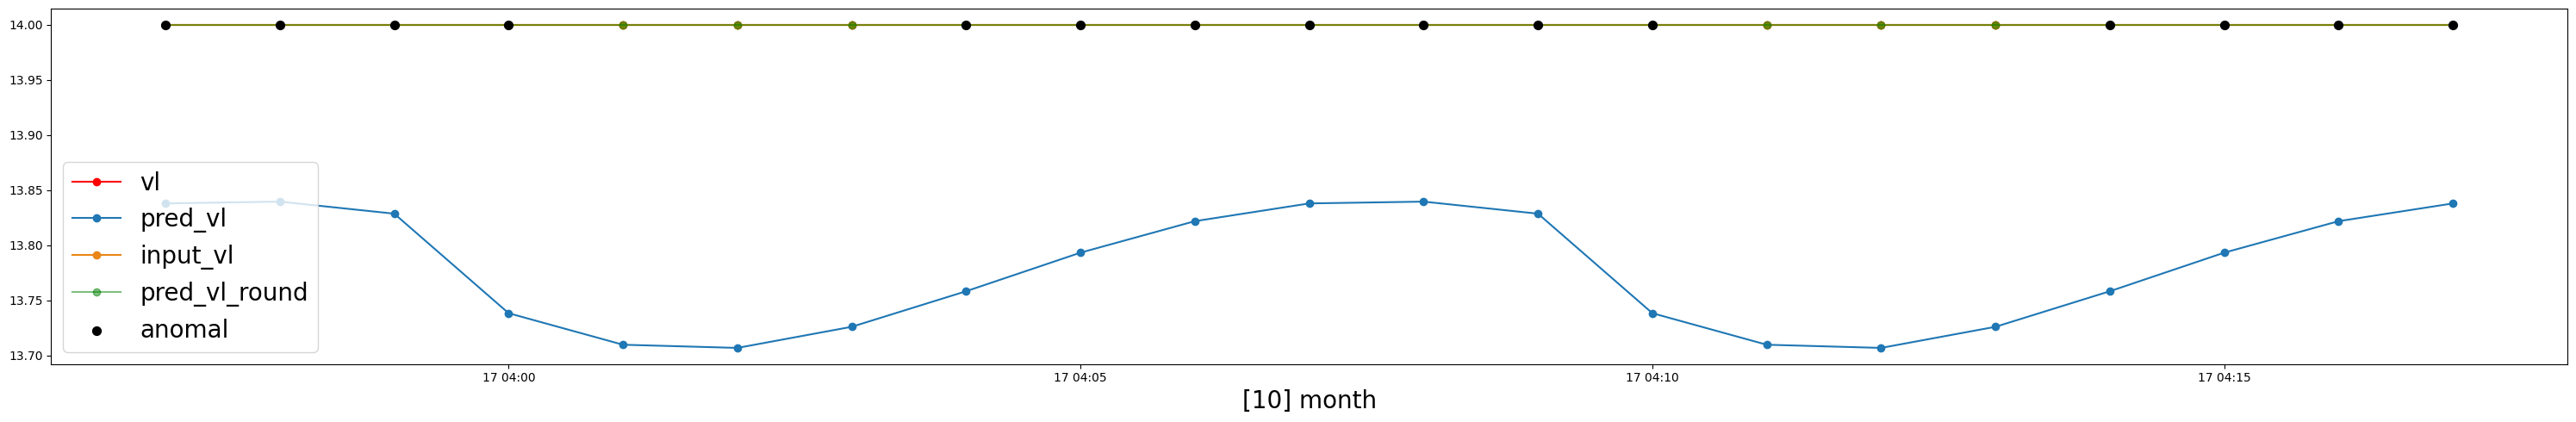

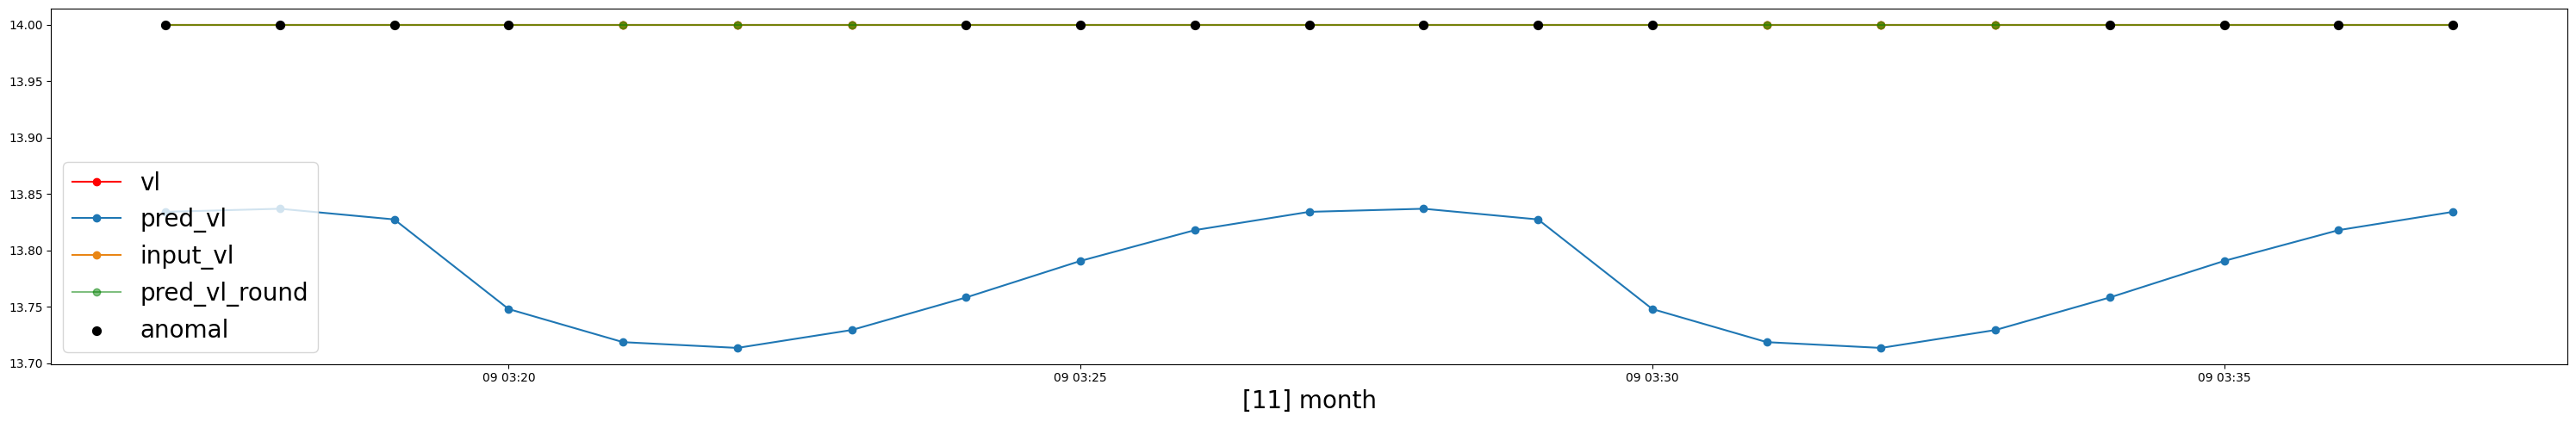

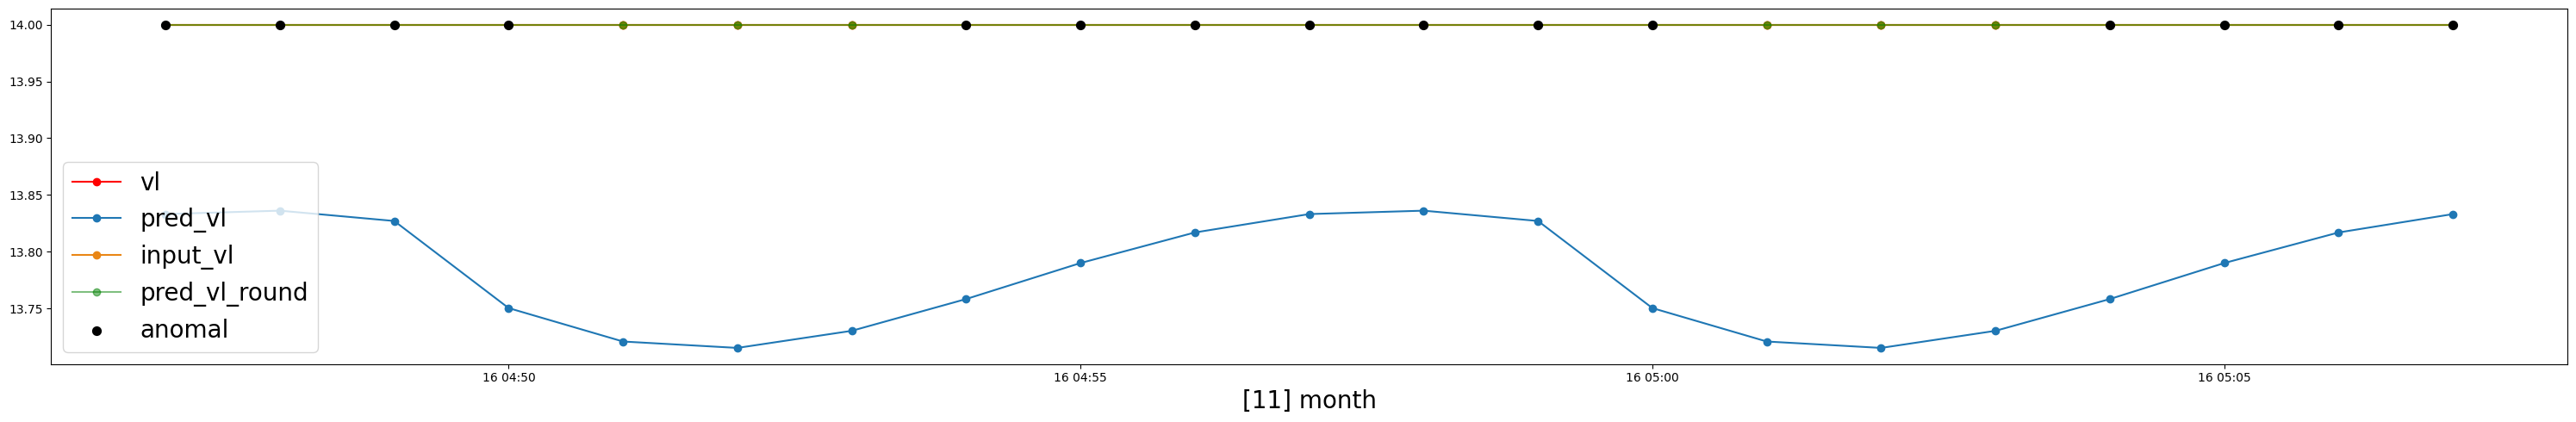

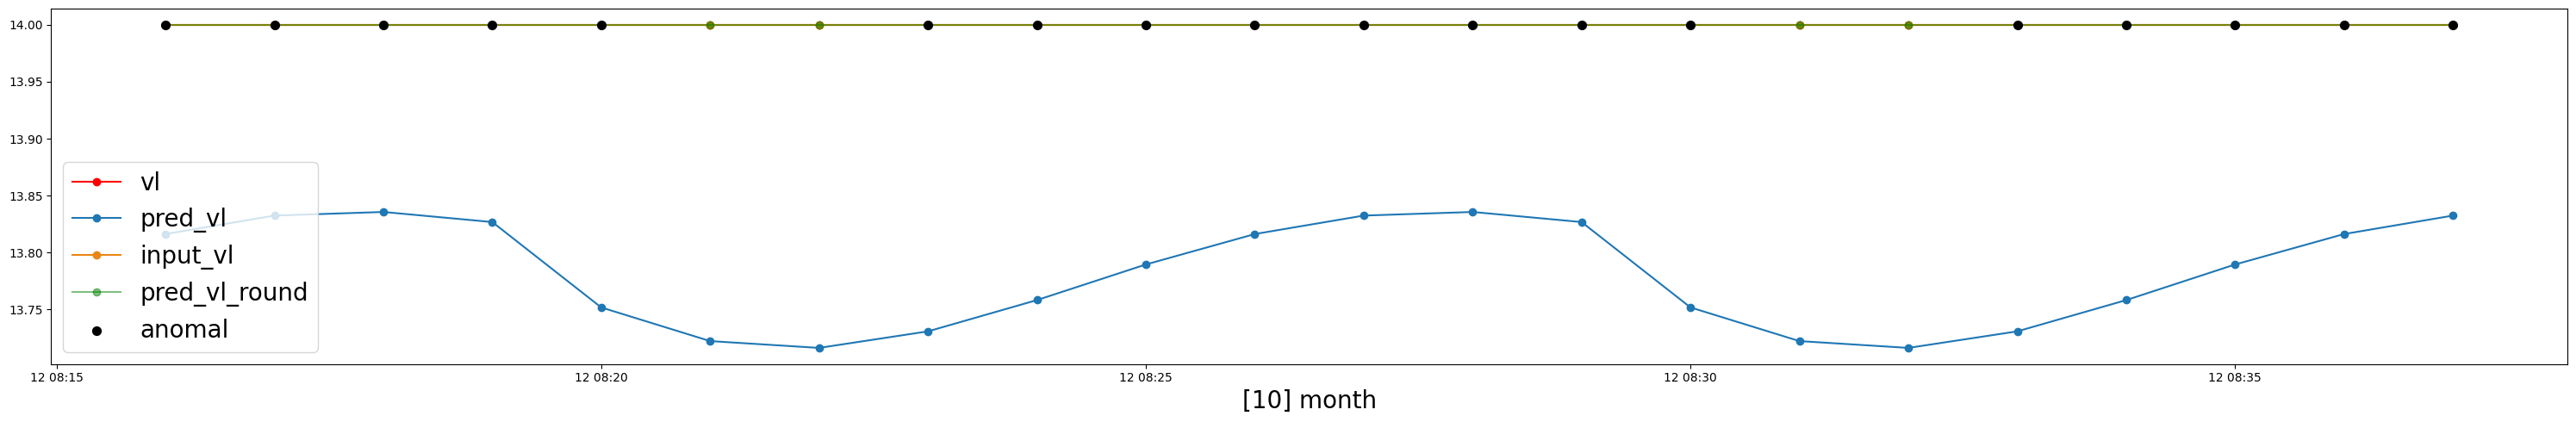

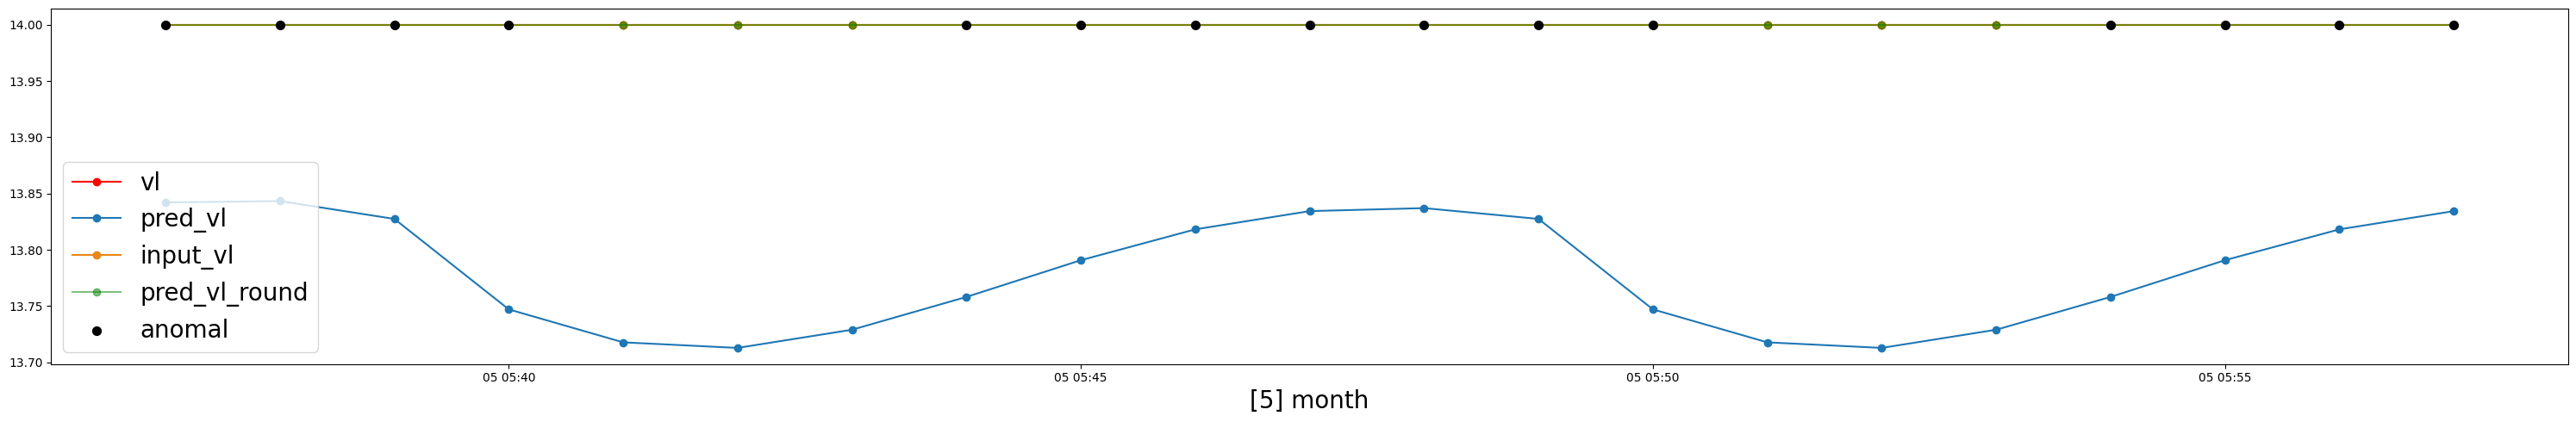

In [88]:
# 이상치 탐지 결과 그래프
gra_anomaly(anomal_df,7,gwangjoo_train_df,True)

152


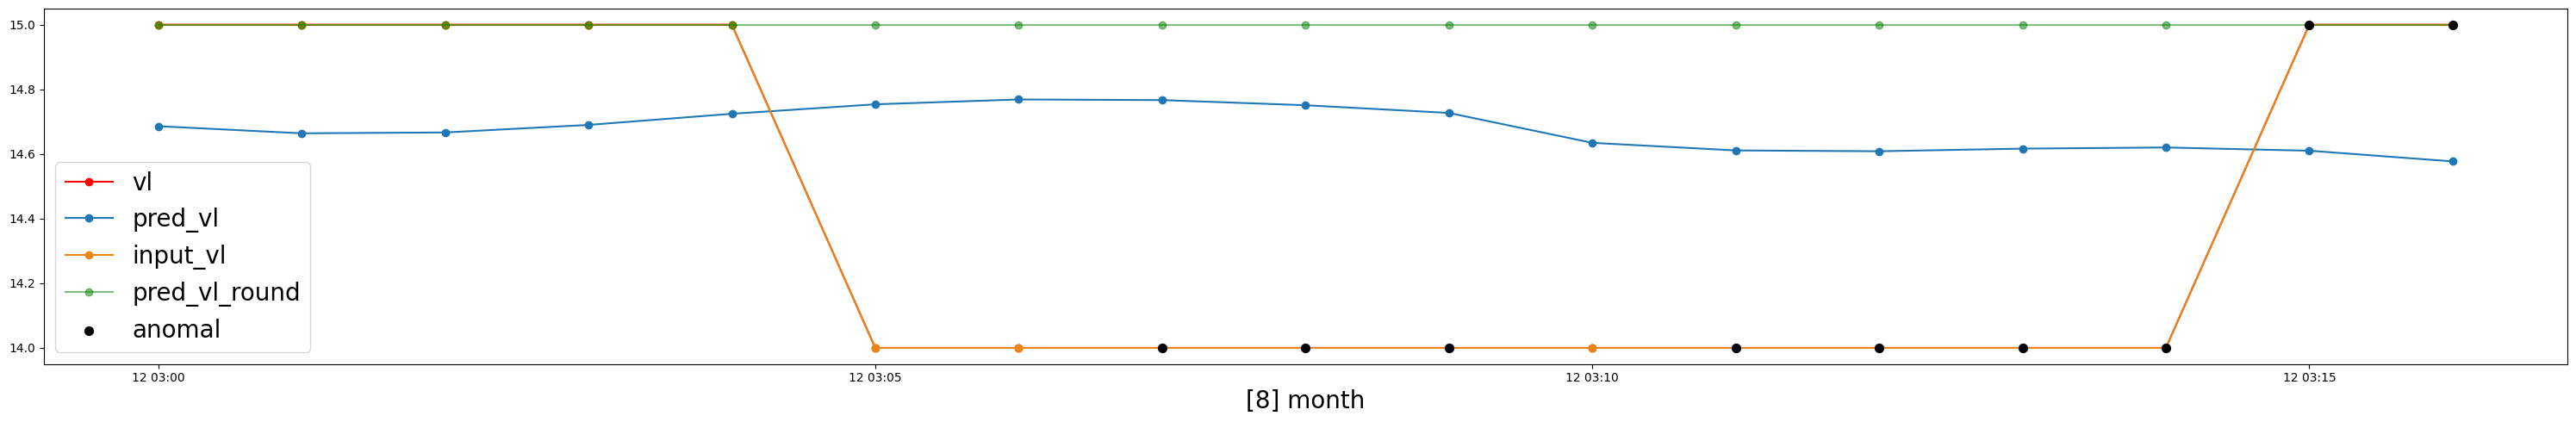

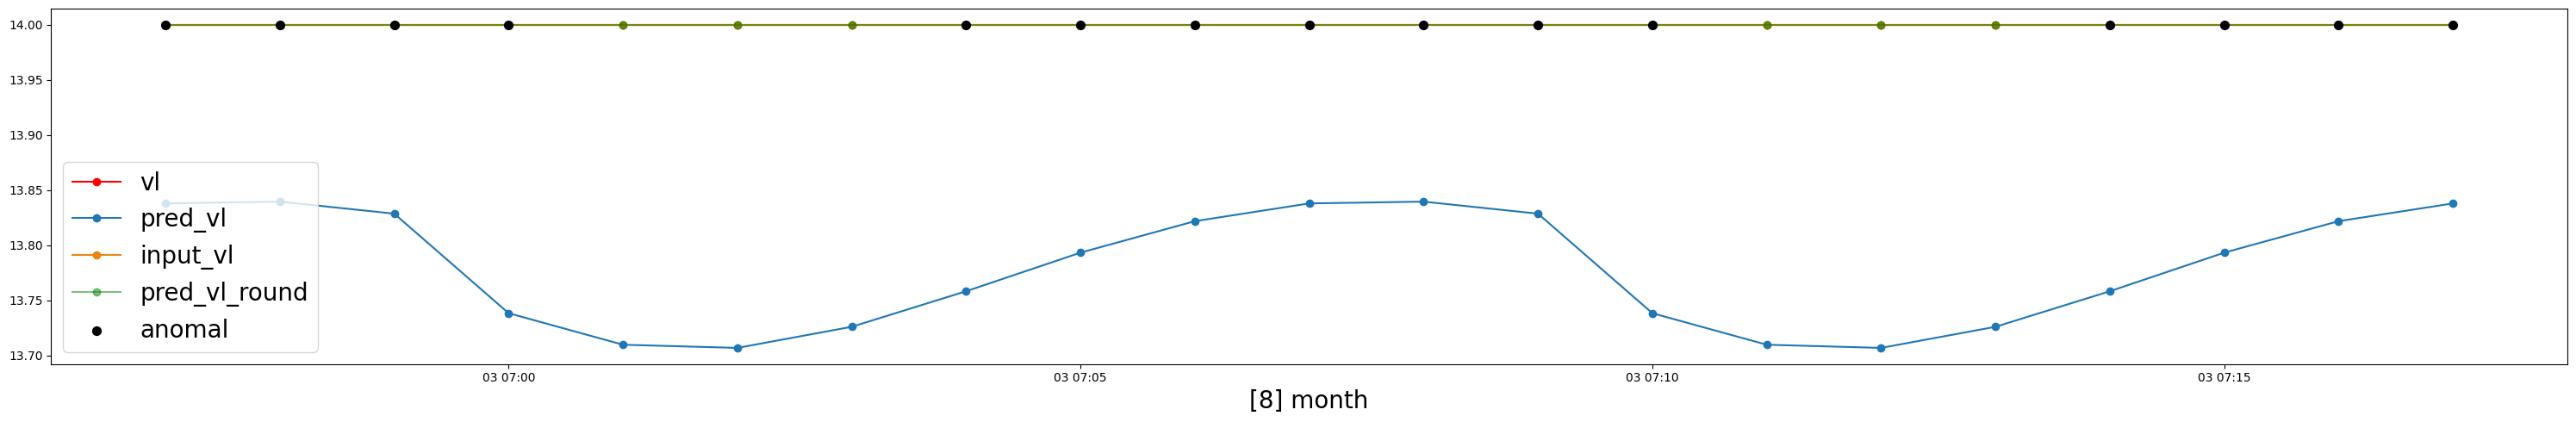

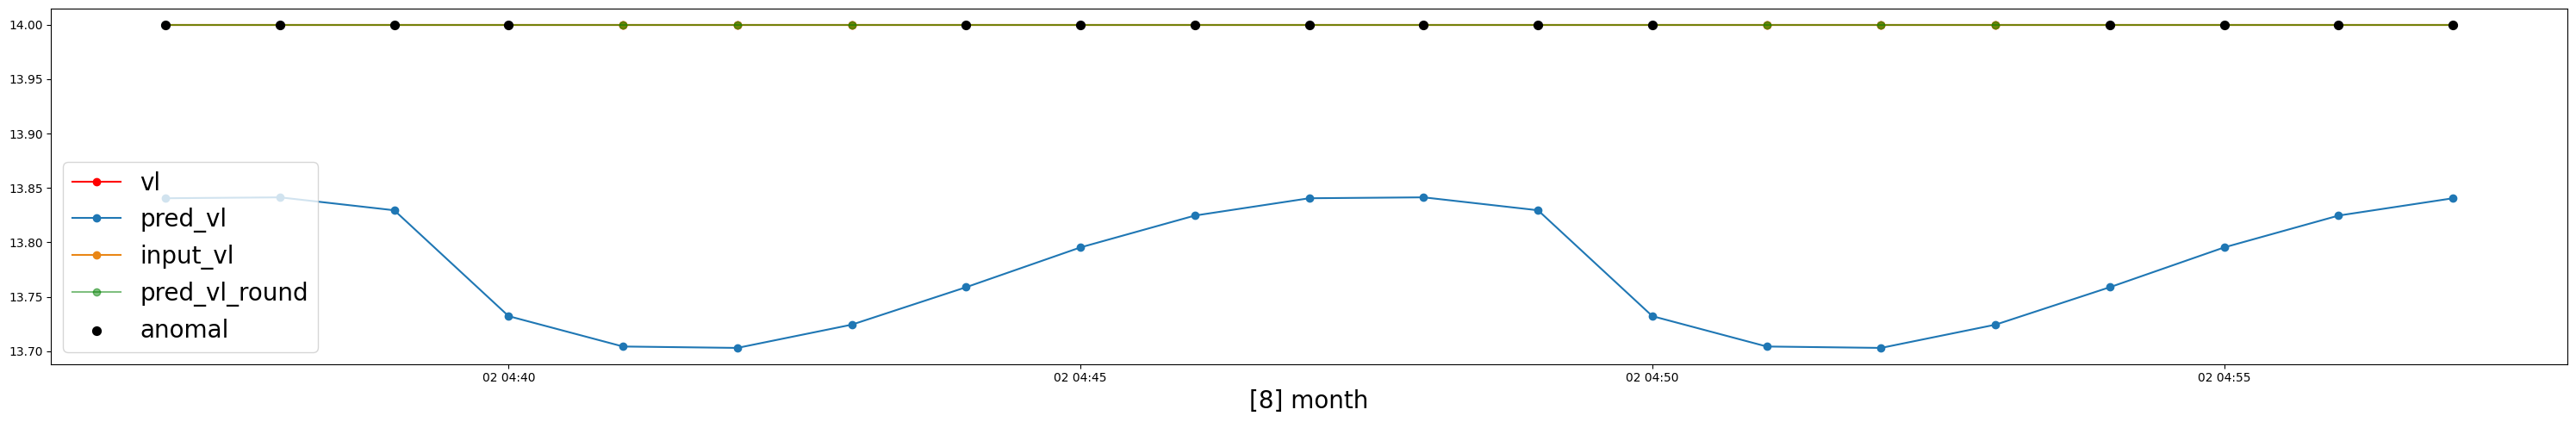

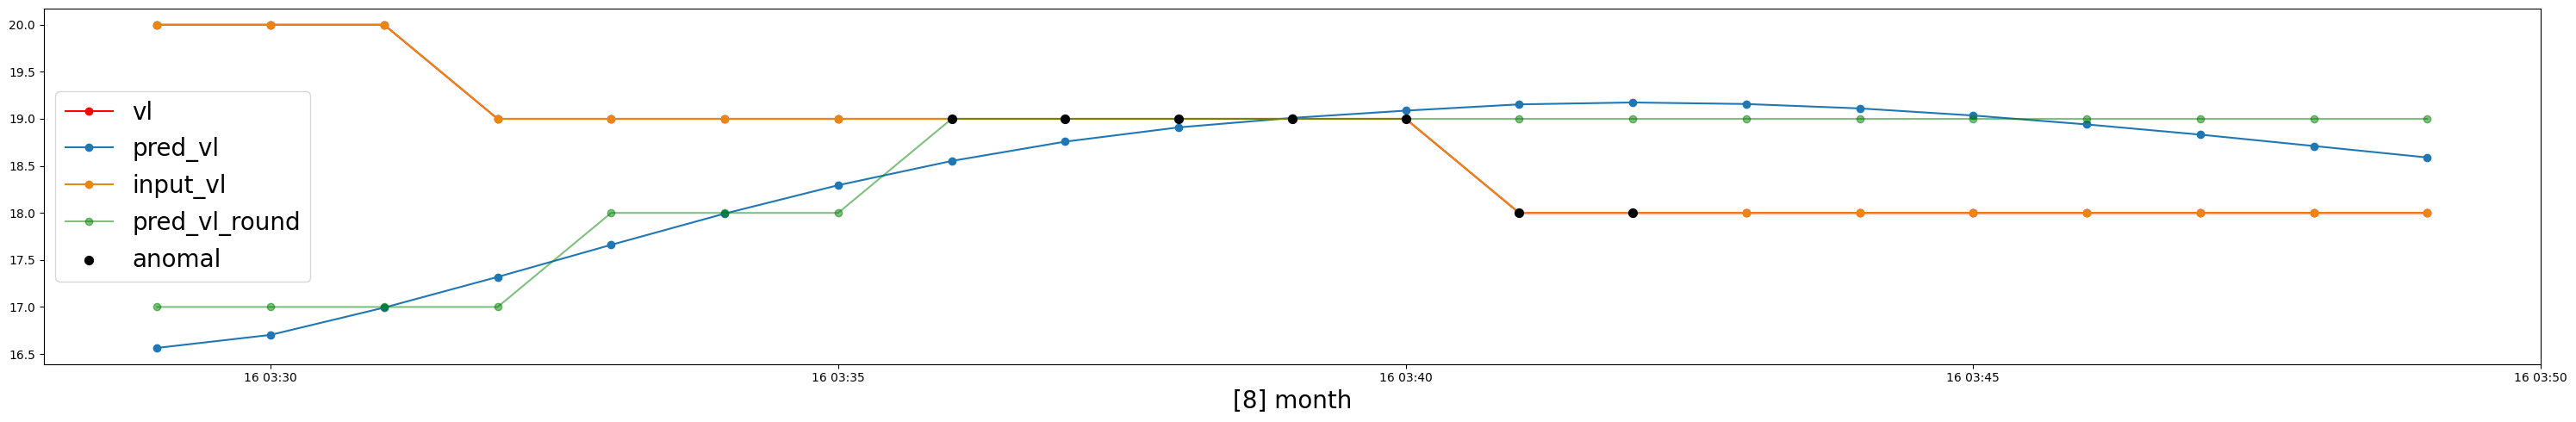

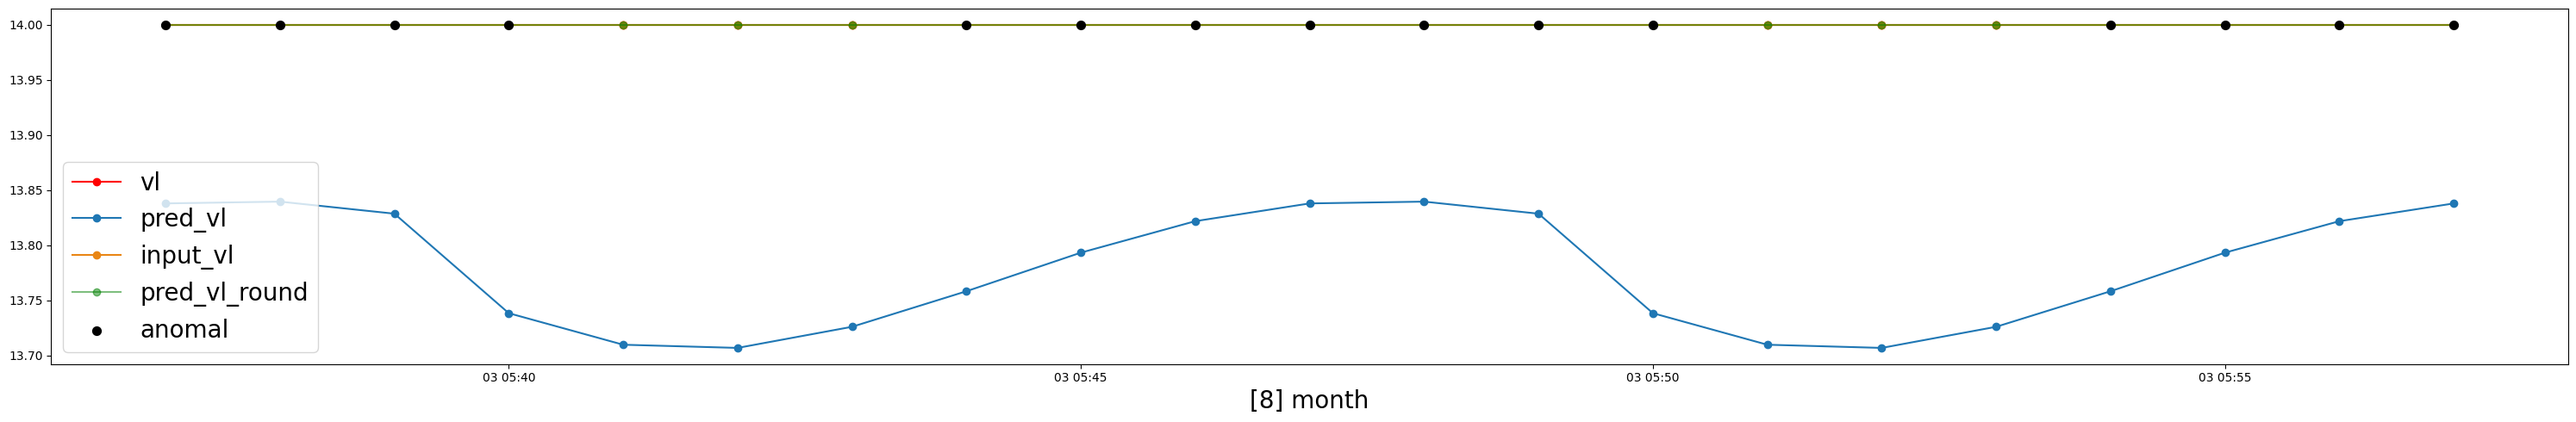

In [93]:
gra_anomaly(anomal_df,7,gwangjoo_train_df,True,m=8)

### iqr

In [65]:
# threshold 설정
per_threshold = thres('iqr', vl_mse)

# 이상치 탐지
anomaly = vl_mse > per_threshold
print(sum(anomaly))

# 모델 예측값 계산
results = pred_val(30,pred_data)

0.01963381981371607
538


100%|██████████| 394530/394530 [00:00<00:00, 550672.38it/s]


In [66]:
# 데이터 프레임 생성
anomal_df = pd.DataFrame({'date':gwangjoo_train_df.loc[29:,'dates'],'vl':gwangjoo_train_df.loc[29:,'vl'],'anomal':anomaly})

anomal_df['date'] = pd.to_datetime(anomal_df['date'])

anomal_df['pred_vl'] = results

anomal_df['pred_vl'] = mm_sclaer.inverse_transform(anomal_df[['vl','pred_vl','pred_vl']])[:,1]

anomal_df['pred_vl_round'] = round(anomal_df['pred_vl'])

118


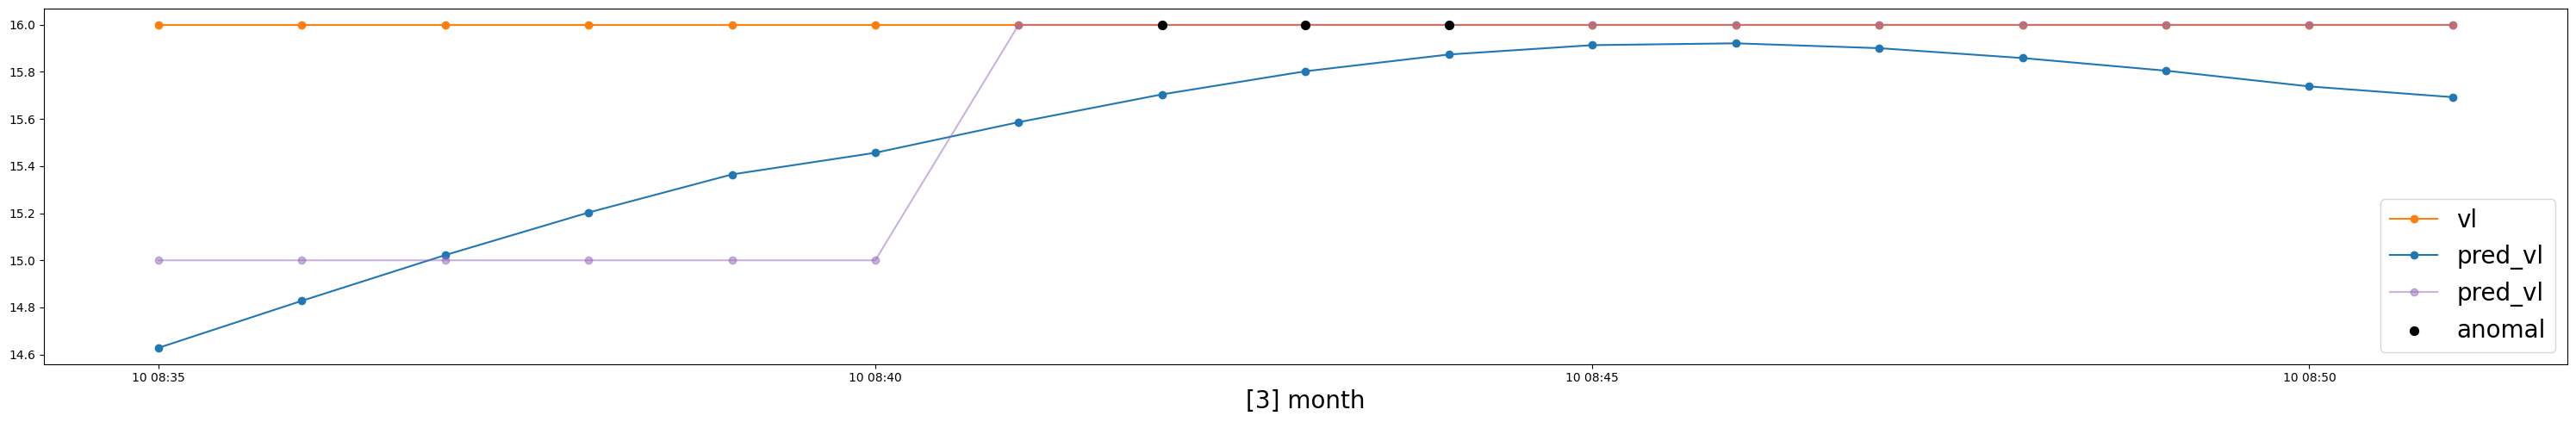

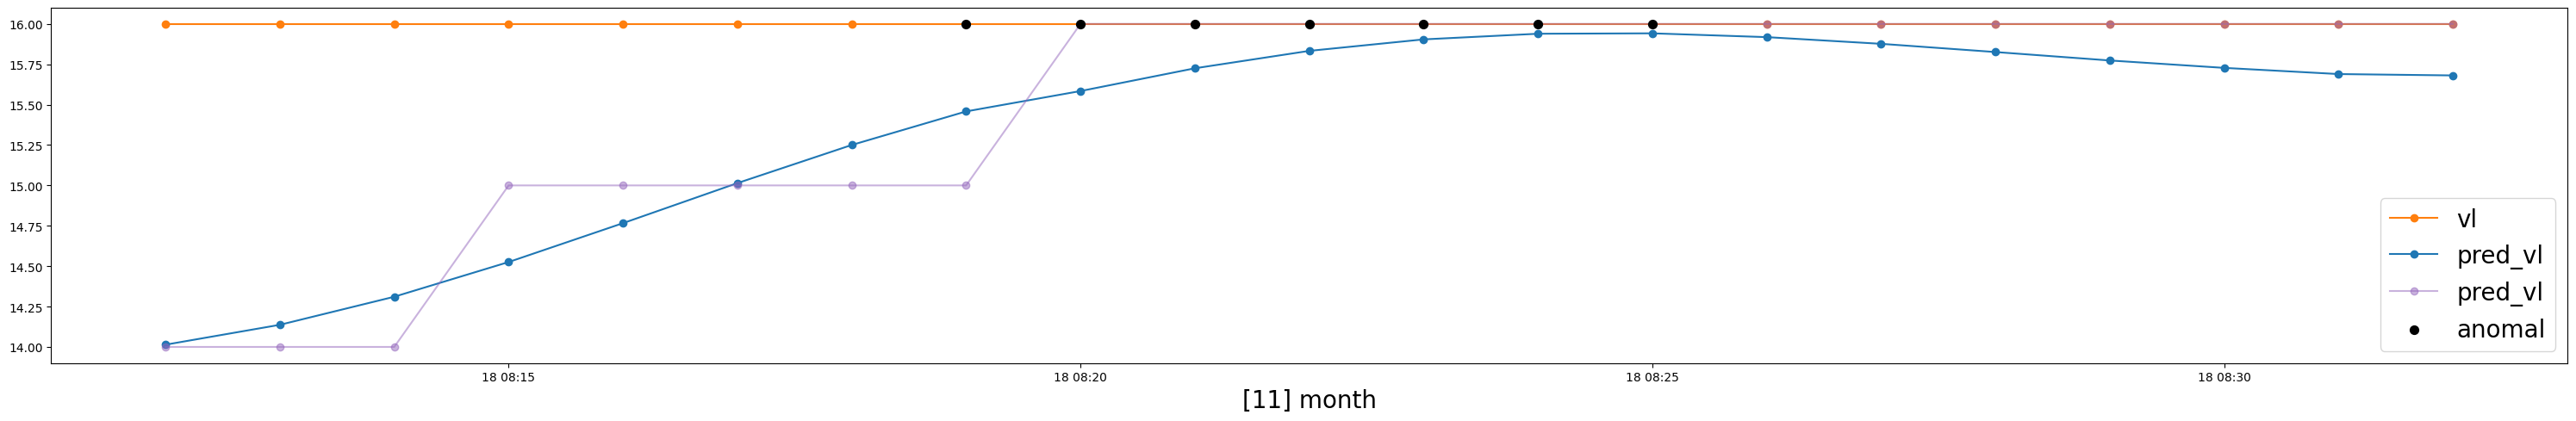

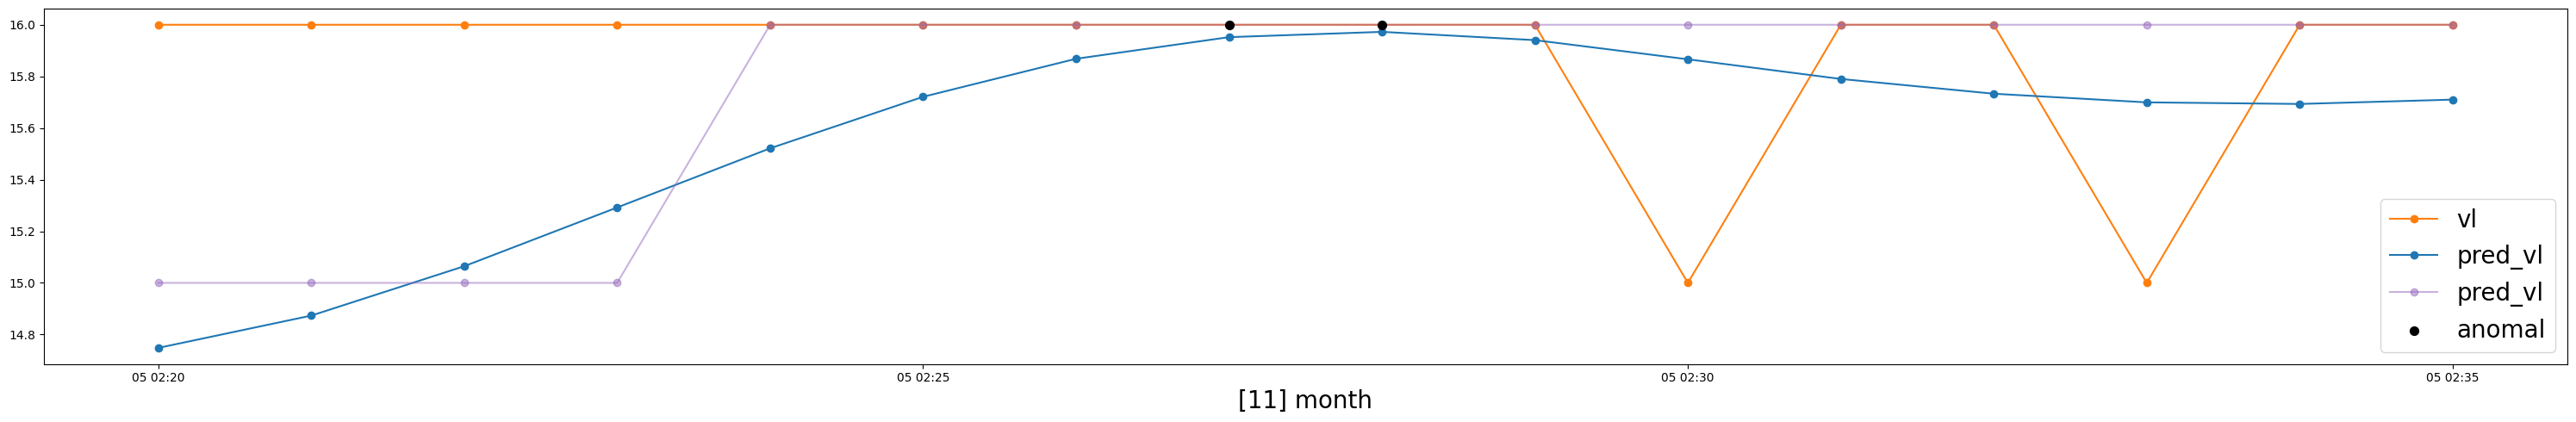

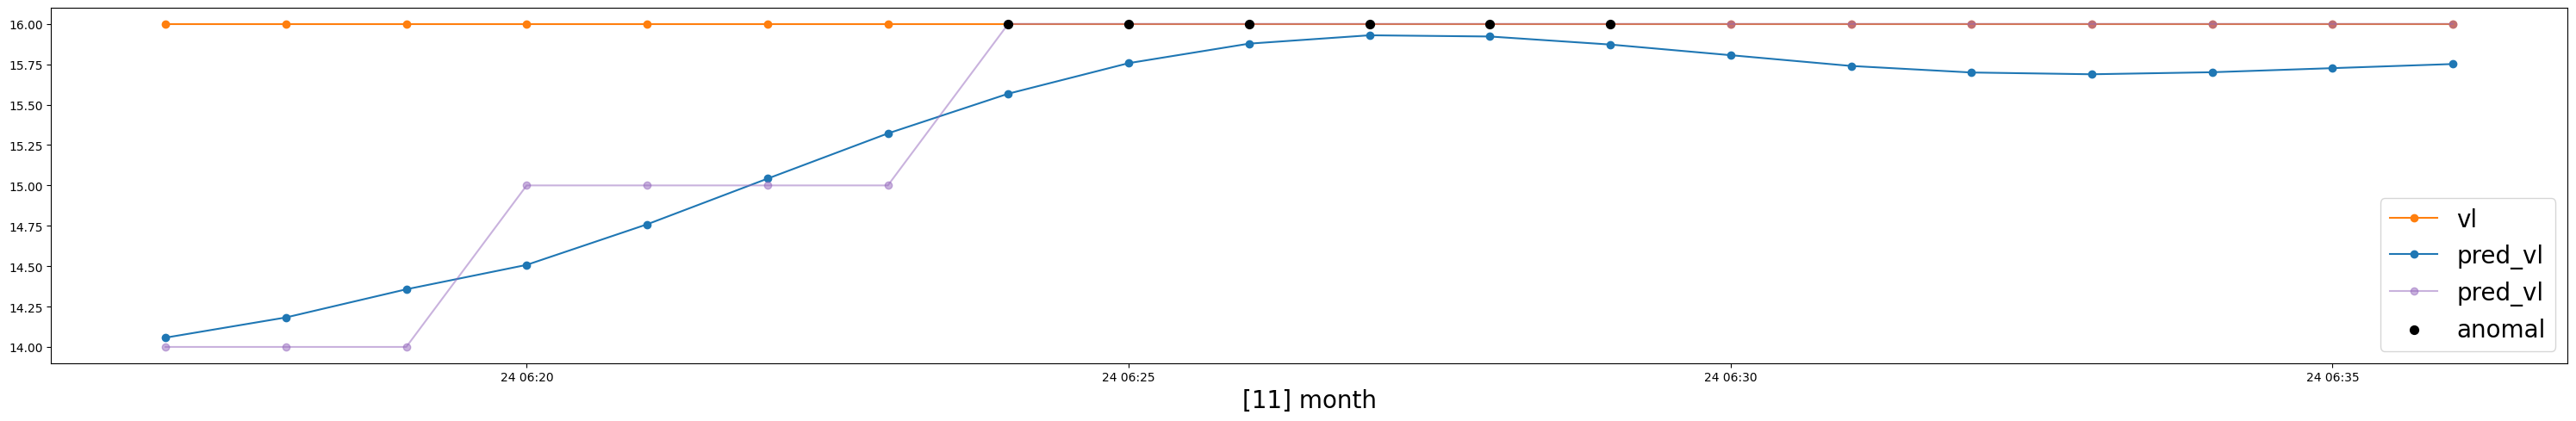

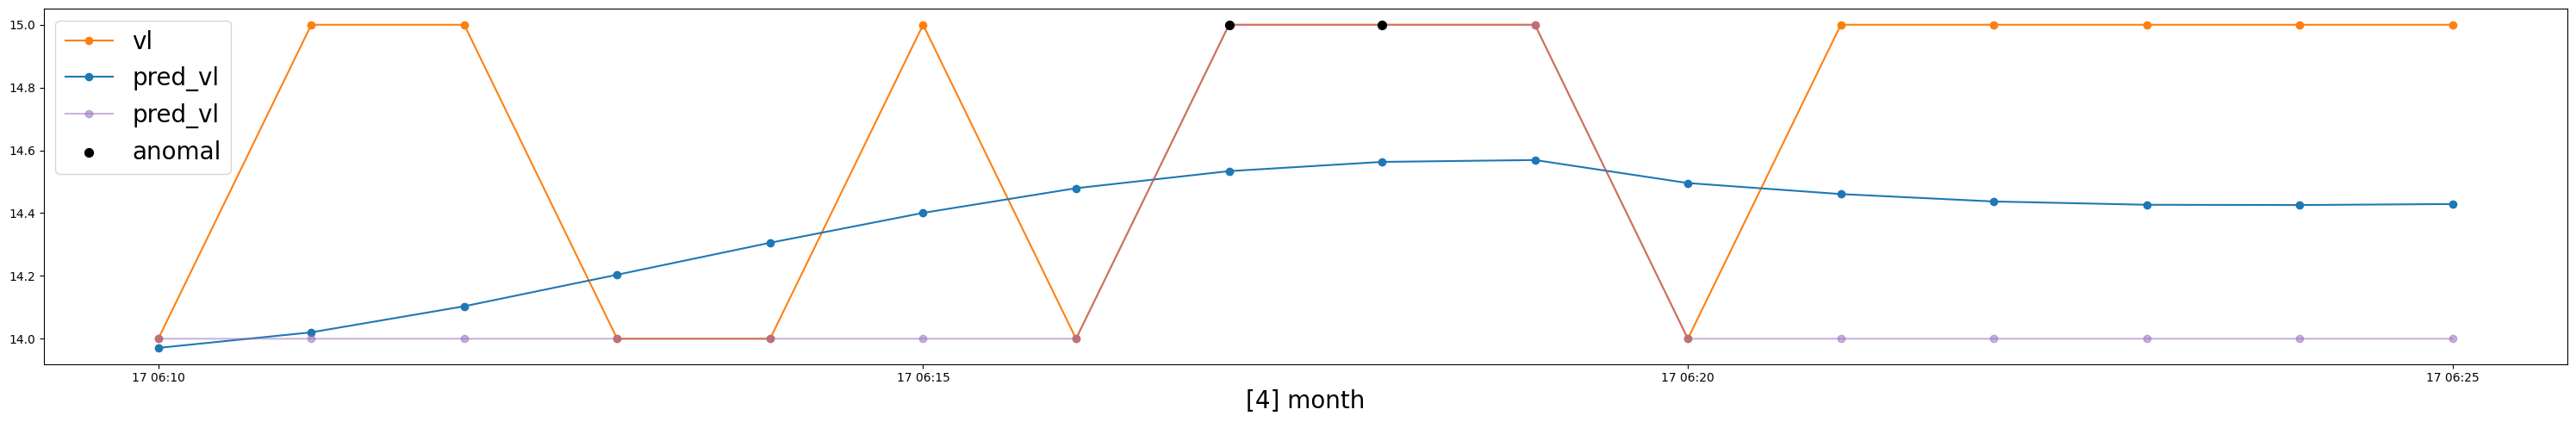

In [67]:
# 이상치 탐지 결과 그래프
gra_anomaly(anomal_df,7,True)

12


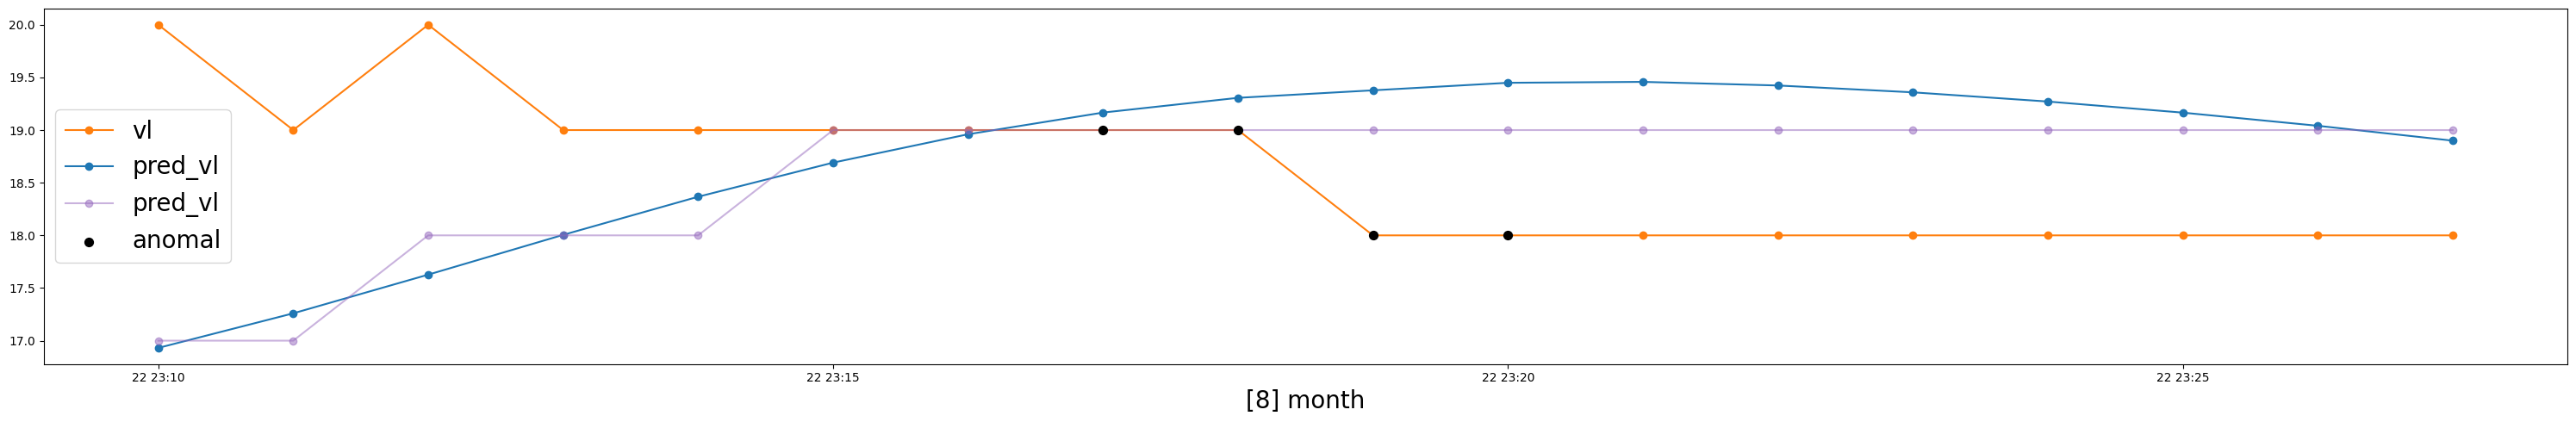

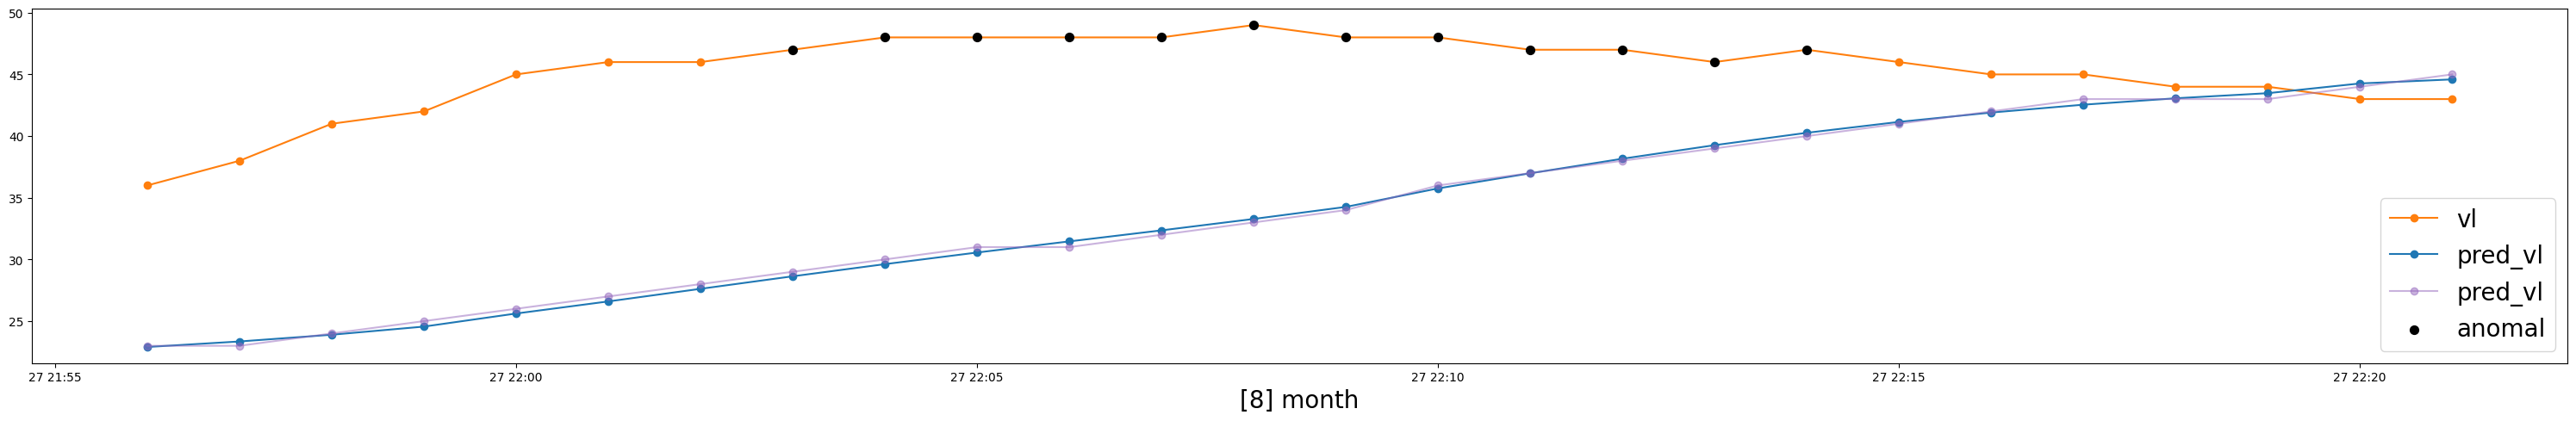

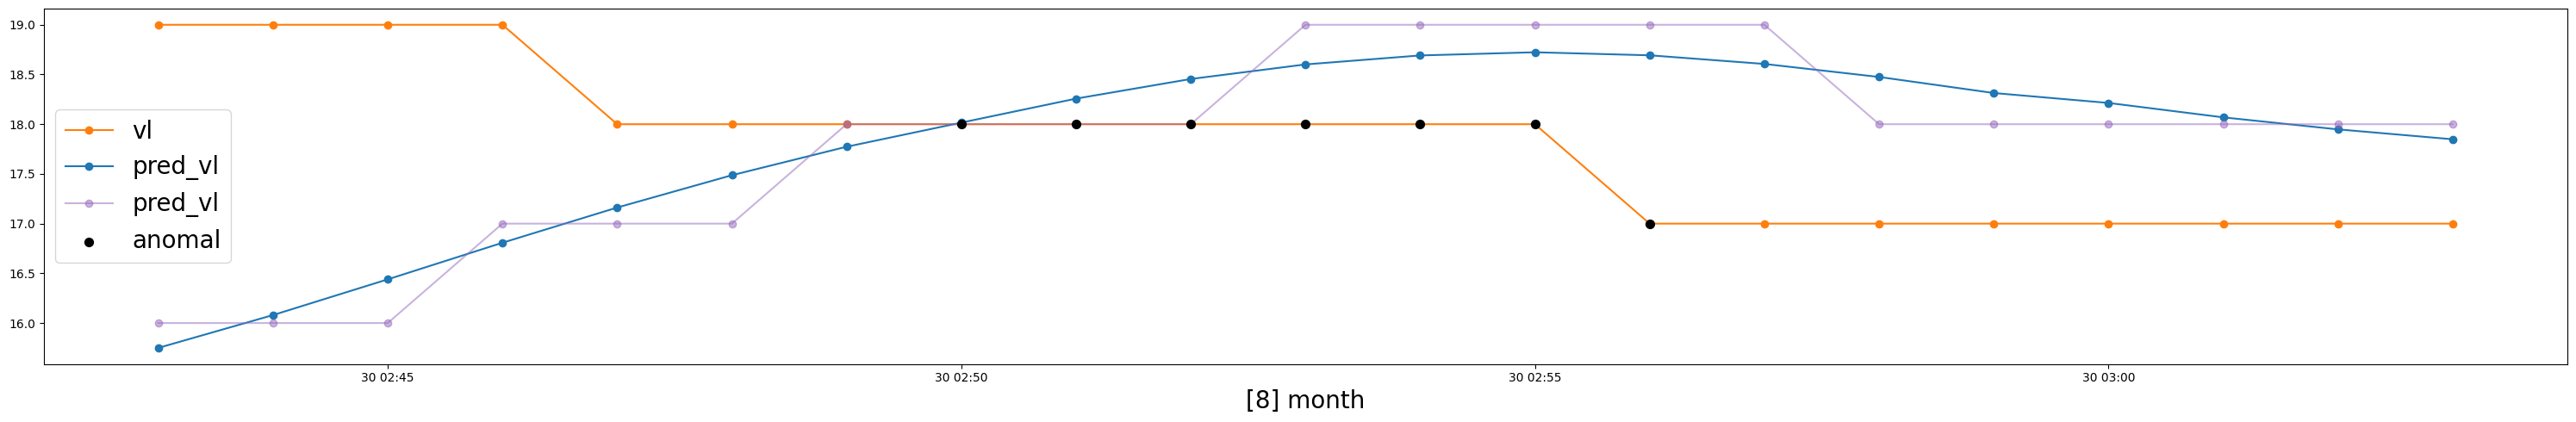

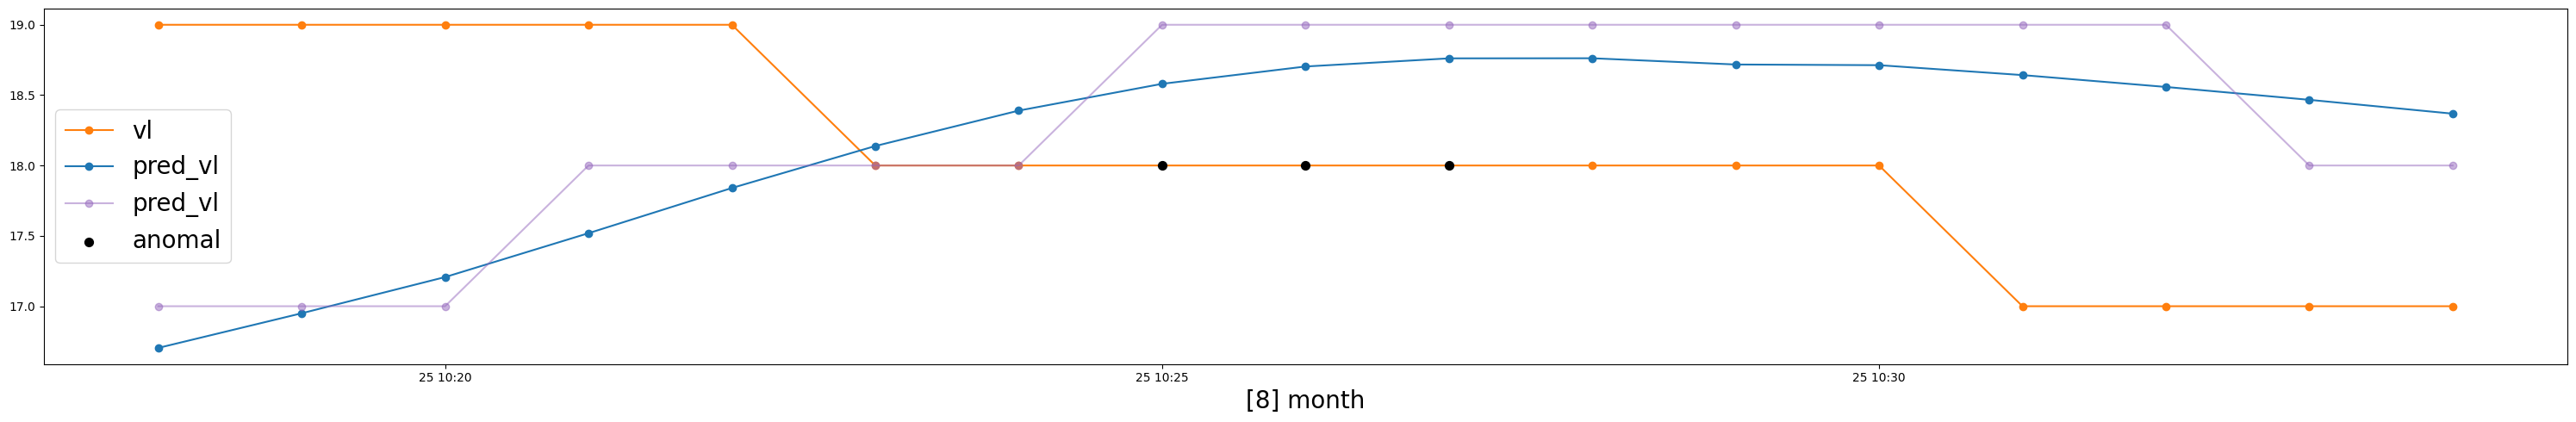

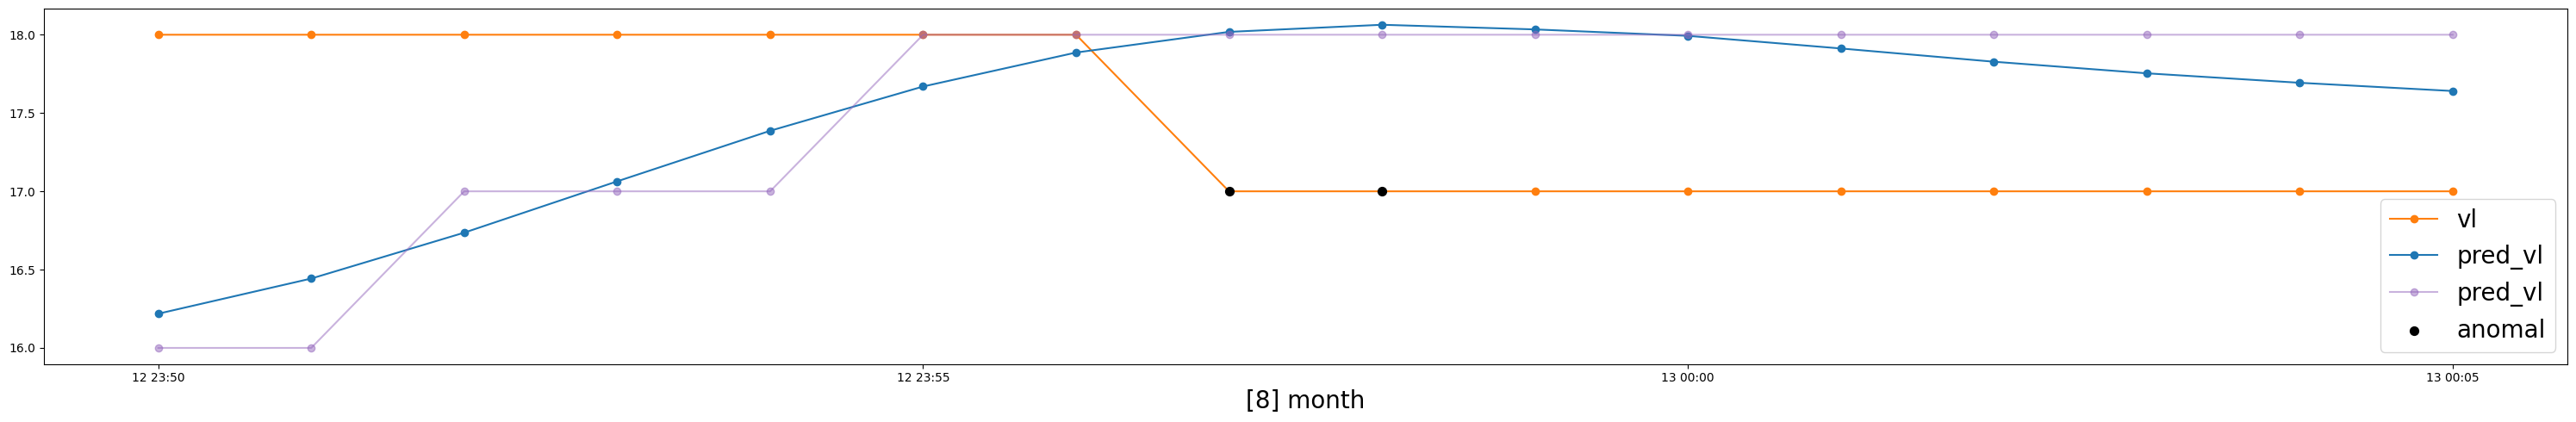

In [68]:
gra_anomaly(anomal_df,7,True,m=8)

### mean + k * std

In [69]:
# threshold 설정 k=3
per_threshold = thres('meank', vl_mse, k=3)

# 이상치 탐지
anomaly = vl_mse > per_threshold
print(sum(anomaly))

# 모델 예측값 계산
results = pred_val(30,pred_data)

0.02464147473576491
87


100%|██████████| 394530/394530 [00:00<00:00, 502092.16it/s]


In [70]:
# 데이터 프레임 생성
anomal_df = pd.DataFrame({'date':gwangjoo_train_df.loc[29:,'dates'],'vl':gwangjoo_train_df.loc[29:,'vl'],'anomal':anomaly})

anomal_df['date'] = pd.to_datetime(anomal_df['date'])

anomal_df['pred_vl'] = results

anomal_df['pred_vl'] = mm_sclaer.inverse_transform(anomal_df[['vl','pred_vl','pred_vl']])[:,1]

anomal_df['pred_vl_round'] = round(anomal_df['pred_vl'])

4


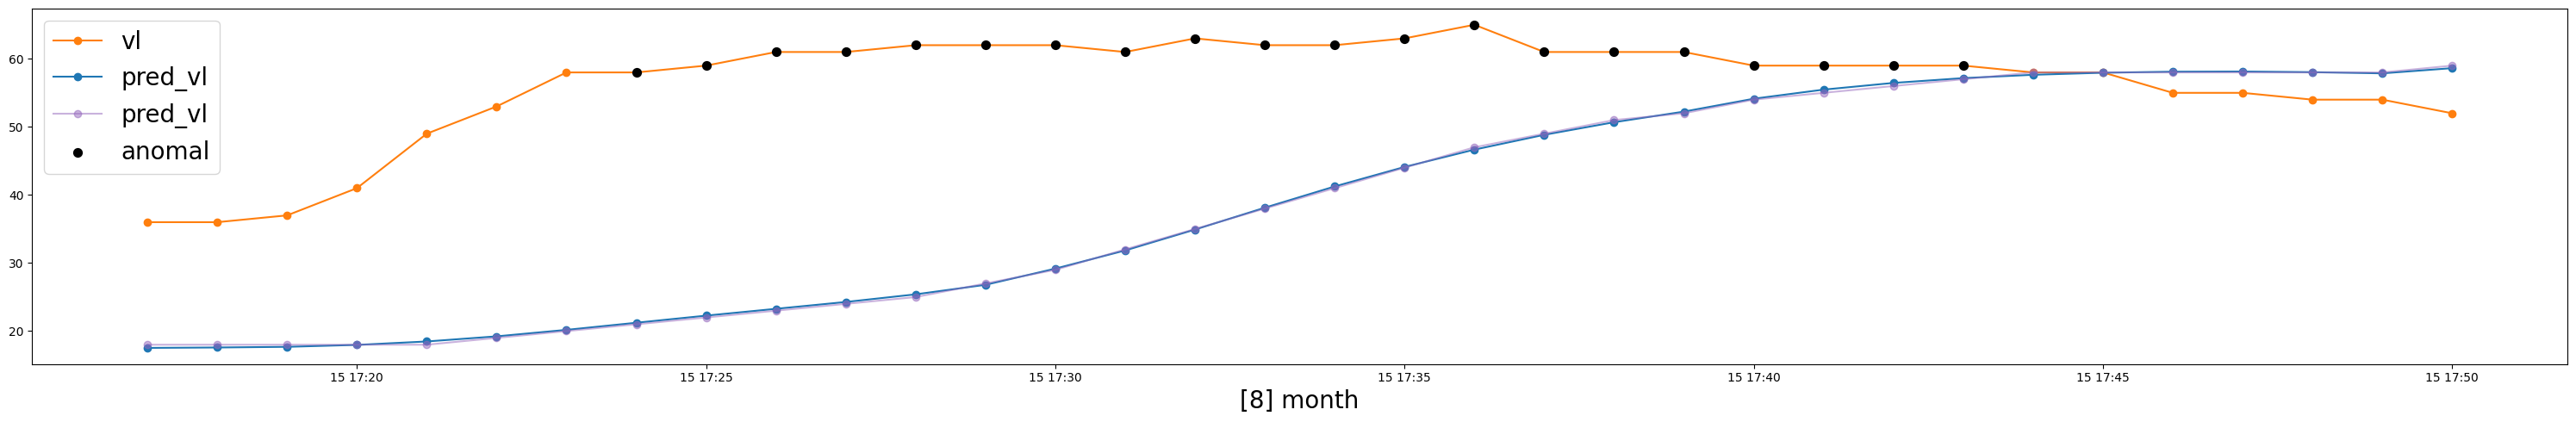

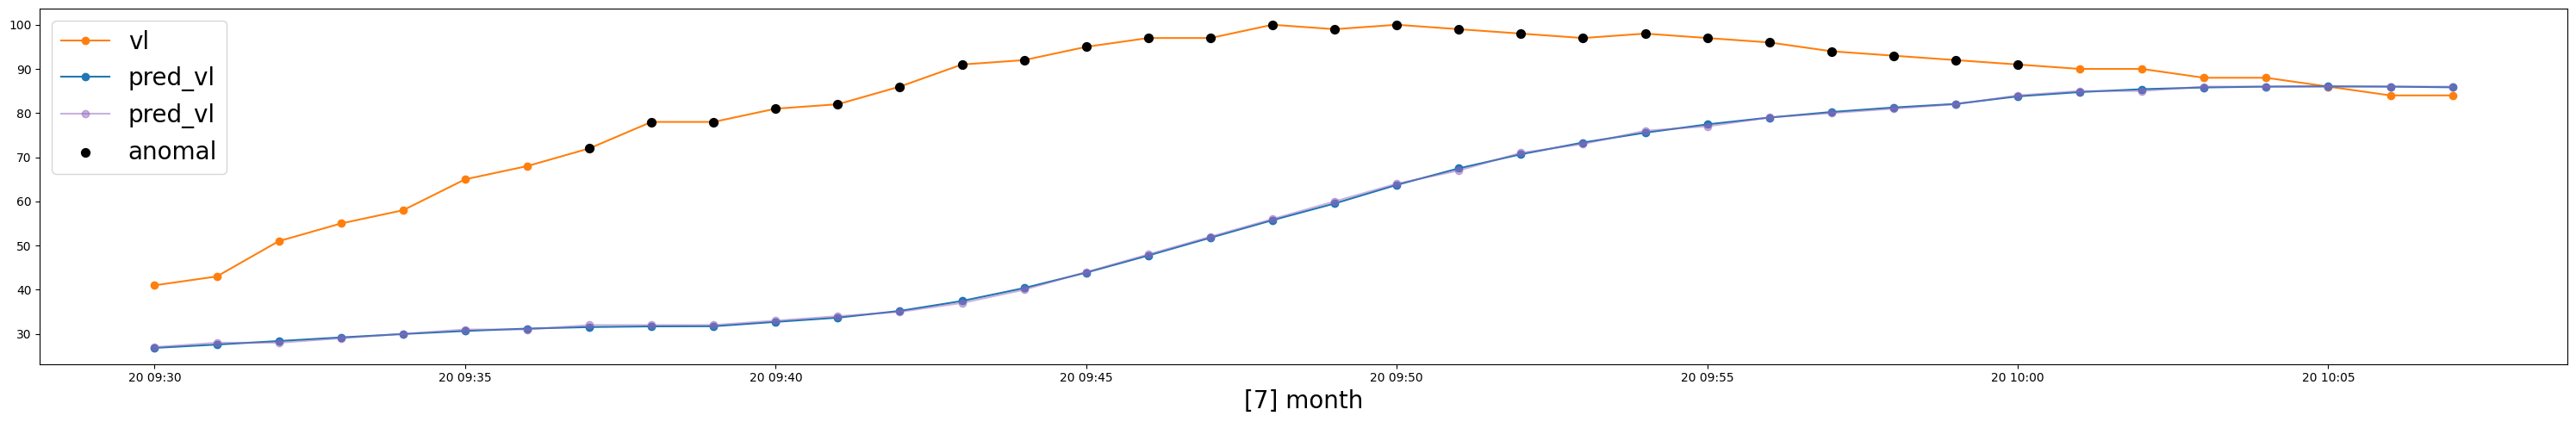

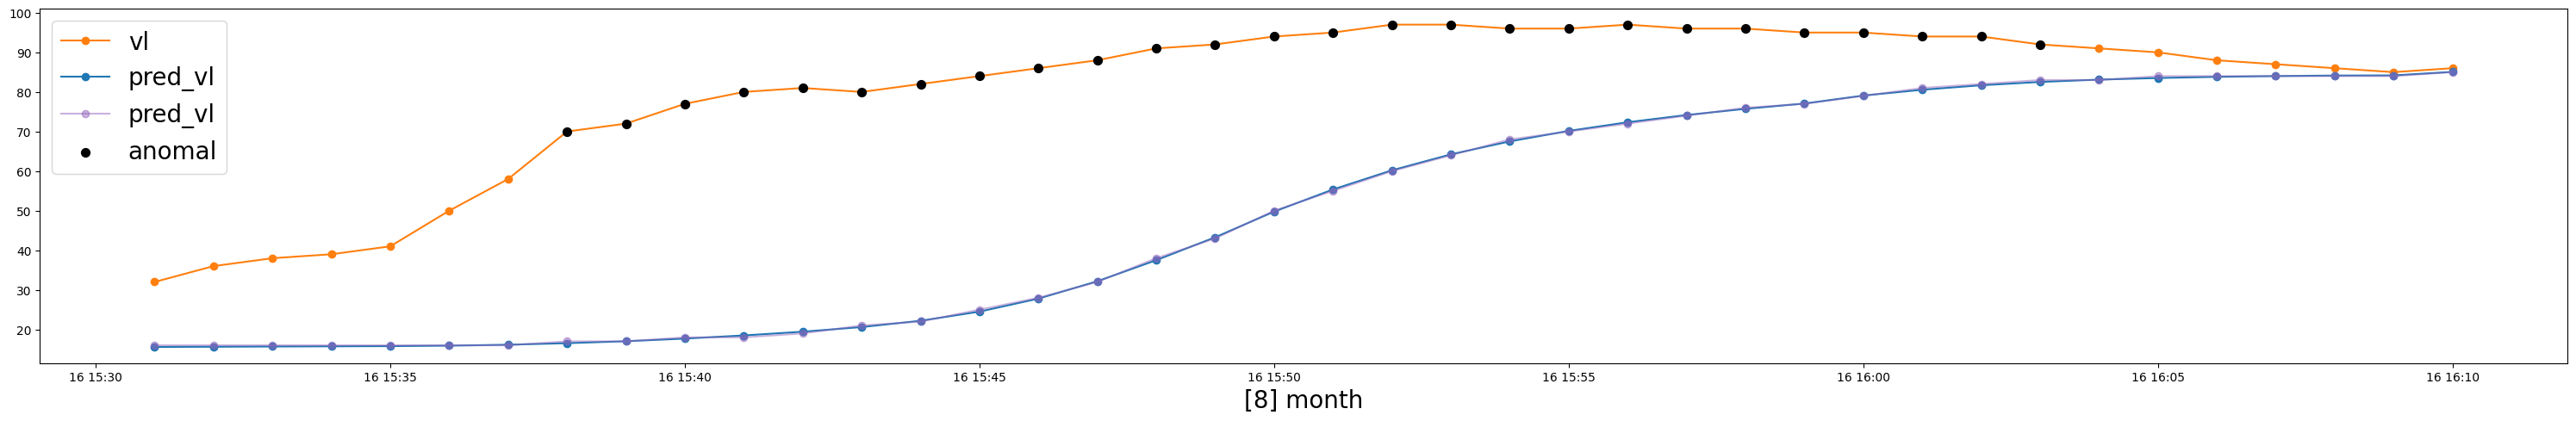

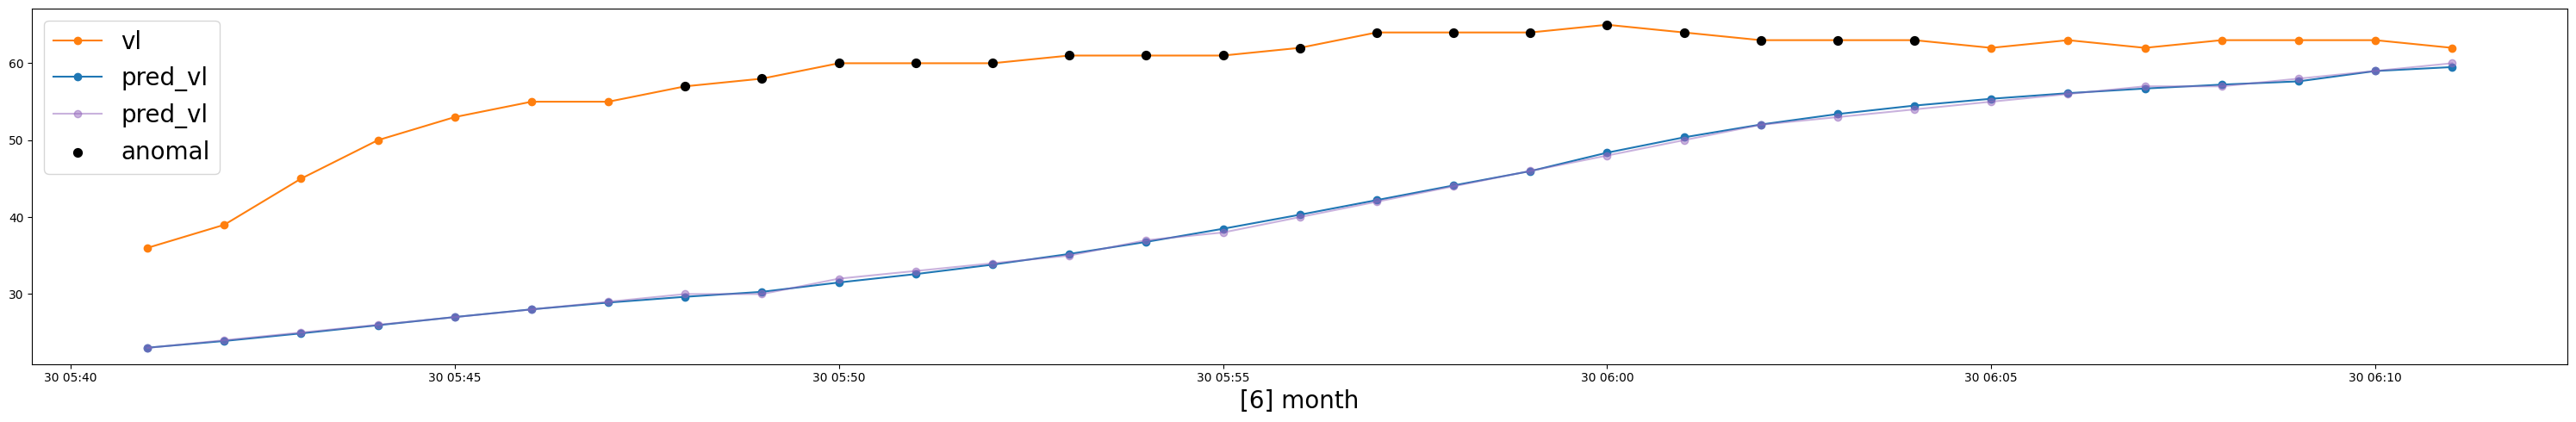

In [71]:
# 이상치 탐지 결과 그래프
gra_anomaly(anomal_df,7,True)